In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
import pyroomacoustics as pra
import sounddevice as sd

In [10]:
# Parameters

# Sound clip Settings 
sound_array_path = '8ch_hello_az0_el30_1m_48k.npy'

# Search spaces for DOA module
search_azimuth = np.linspace(-180., 180., 30) * np.pi / 180
search_elevation = np.linspace(90, 180., 30) * np.pi / 180

# Location of source relative to microphone array
azimuth = 0. / 180. * np.pi
elevation = 30. / 180. * np.pi
distance = 1.   # meters

# Somewhat static parameters
sound_speed = 343.    # speed of sound
sample_rate = 48000   # sampling frequency
nfft = 256            # FFT size
freq_range = [300, 3000]

In [18]:
# Create 2D mic array [x, y, z] based on Matrix Voice
#https://matrix-io.github.io/matrix-documentation/matrix-voice/resources/microphone/

# Start with mic placement in mm, convert to m, transpose
mic_array = np.array([[0.0, 0.0, 0.0],
                      [-38.13, 3.58, 0.0],
                      [-20.98, 32.04, 0.0],
                      [11.97, 36.38, 0.0],
                      [35.91, 13.32, 0.0],
                      [32.81, -19.77, 0.0],
                      [5.00, -37.97, 0.0],
                      [-26.57, -27.58, 0.0]])
mic_array /= 1000.
mic_array = mic_array.T
channels = mic_array.shape[1]
print(mic_array)

[[ 0.      -0.03813 -0.02098  0.01197  0.03591  0.03281  0.005   -0.02657]
 [ 0.       0.00358  0.03204  0.03638  0.01332 -0.01977 -0.03797 -0.02758]
 [ 0.       0.       0.       0.       0.       0.       0.       0.     ]]


In [19]:
# Load audio file
signals = np.load(sound_array_path)
signals = signals.T
print(signals.shape)

(8, 48000)


### Simulation
Simulate room and add audio from Channel 0 of recording as a point source at 1 m away and 0° azimuth and 30° elevation up from mic array. Perform sound source localization based on simulated received sound.

In [58]:
# Location of mic array center (in meters, from origin)
mic_x = 5.
mic_y = 5.
mic_z = 0.

# We only want one channel (mono) for simulated sound source
channel_for_source = 0

# Create white noise for the room
snr_db = 20.     # Signal-to-noise ratio
sigma2 = 10**(-snr_db / 10) / (4. * np.pi * distance)**2

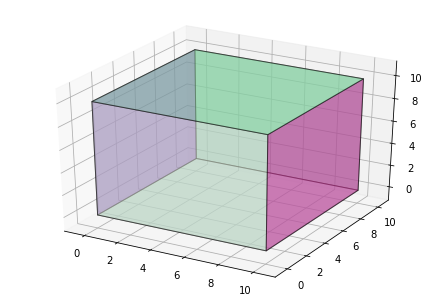

In [59]:
# Create an anechoic room (absorption = 1)
absorption = 1.0
max_order = 0
room_dim = np.array([10., 10.])
room_height = 10.

corners = np.array([[0, 0], [room_dim[0], 0], [room_dim[0], room_dim[1]], [0, room_dim[1]]]).T  # [x,y]
room = pra.Room.from_corners(corners, absorption=absorption, fs=sample_rate, max_order=max_order, sigma2_awgn=sigma2)
room.extrude(room_height)

fig, ax = room.plot()
ax.set_xlim([-1, 11])
ax.set_ylim([-1, 11])
ax.set_zlim([-1, 11]);

[(0.0, 1.0), (4.8, 5.2), (4.8, 5.2)]

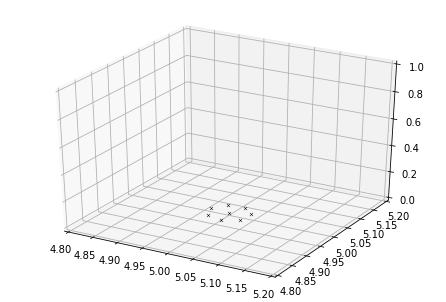

In [60]:
# Put simulated microphone array in the middle of the room, on the floor
mic_center = np.array([[mic_x, mic_y, mic_z],
                      [mic_x, mic_y, mic_z],
                      [mic_x, mic_y, mic_z],
                      [mic_x, mic_y, mic_z],
                      [mic_x, mic_y, mic_z],
                      [mic_x, mic_y, mic_z],
                      [mic_x, mic_y, mic_z],
                      [mic_x, mic_y, mic_z]])
mic_loc = np.add(mic_array, mic_center.T)
room.add_microphone_array(pra.MicrophoneArray(mic_loc, room.fs))

# Show the mic array
fig, ax = room.plot()
ax.set(xlim=(4.8, 5.2), ylim=(4.8, 5.2), zlim=(0.0, 1.0))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Adding source at (dist, az, el): 1.0 0.0 0.5235987755982988
Cartesian coords (x, y, z): [5.866025403784438, 5.0, 0.4999999999999999]


[(0.0, 10.0), (0, 10.0), (0, 10.0)]

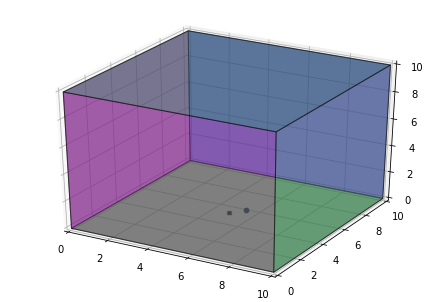

In [61]:
# Add audio (just channel 0 from recording) as just a point source away from mic array
duration_samples = signals.shape[0]

# Convert polar coordinates to Cartesian coordinates
source_location = [mic_x + (distance * np.cos(azimuth) * np.sin(np.pi / 2 - elevation)),
                   mic_y + (distance * np.sin(azimuth) * np.sin(np.pi / 2 - elevation)),
                   mic_z + (distance * np.cos(np.pi / 2 - elevation))]
print('Adding source at (dist, az, el):', distance, azimuth, elevation)
print('Cartesian coords (x, y, z):', source_location)

# Add sound source to room
room.add_source(source_location, signal=signals[channel_for_source])

# Run room simulation
room.simulate()
fig, ax = room.plot()
ax.set(xlim=(0, 10.0), ylim=(0, 10.0), zlim=(0.0, 10.0))

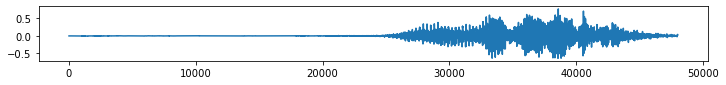

In [69]:
# Play original file
plt.figure(figsize=(12, 1))
plt.plot(signals[channel_for_source])
sd.play(signals[channel_for_source])

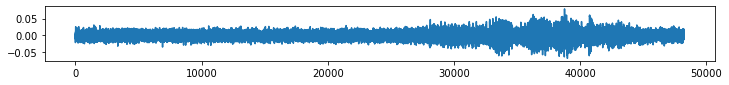

In [73]:
# Play simulated sound as heard by first (center) microphone
plt.figure(figsize=(12, 1))
plt.plot(room.mic_array.signals[0,:])
sd.play(room.mic_array.signals[0,:])

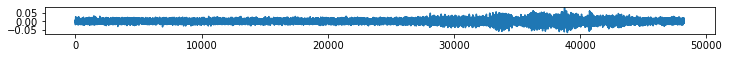

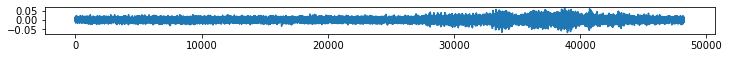

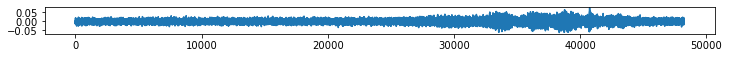

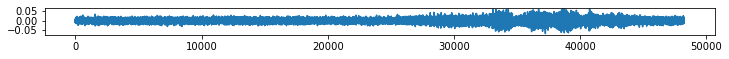

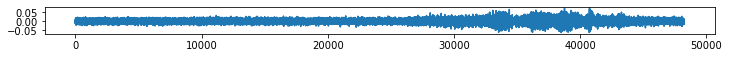

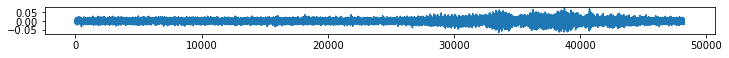

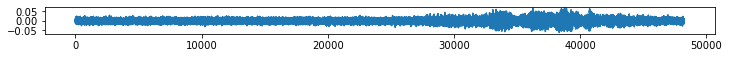

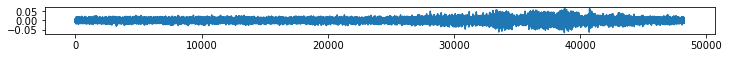

In [79]:
# Plot waveforms from each mic
for i in range(room.mic_array.signals.shape[0]):
    fig = plt.figure(figsize=(12, 0.5))
    ax = fig.add_subplot(111)
    ax.plot(room.mic_array.signals[i,:])
plt.show()

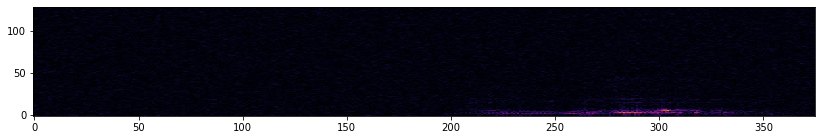

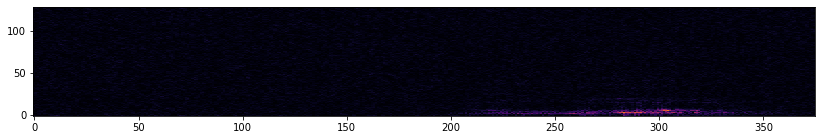

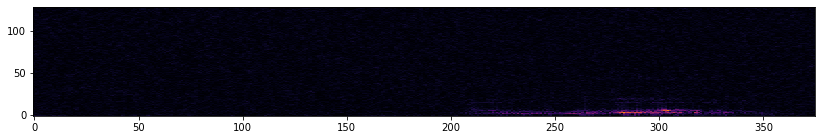

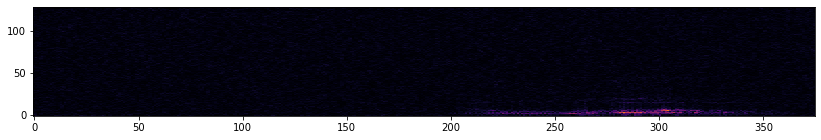

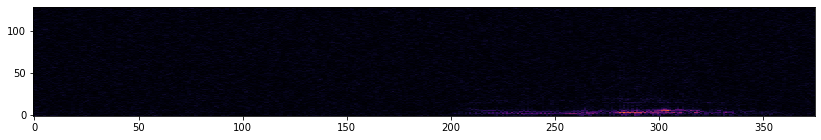

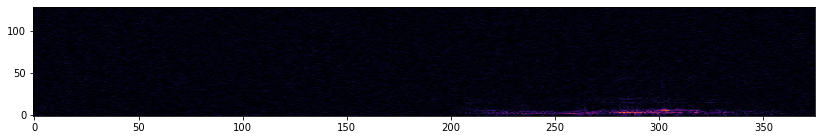

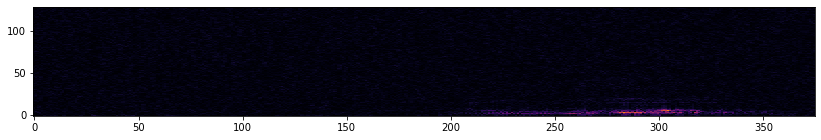

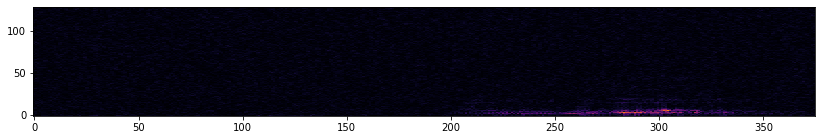

In [90]:
# Compute and plot STFT for all signals
stft = np.array([pra.stft(signal, nfft, nfft // 2, transform=np.fft.rfft).T for signal in room.mic_array.signals])
for X in stft:
    fig = plt.figure(figsize=(14, 2))
    ax = fig.add_subplot(111)
    ax.imshow(np.absolute(X), cmap='inferno', origin='lower', aspect='auto')

No handles with labels found to put in legend.


Actual azimuth (deg): 0.0
Actual elevation (deg): 29.999999999999996
Estimated azimuth (deg): 6.206896551724129
Estimated elevation (deg): 52.75862068965518


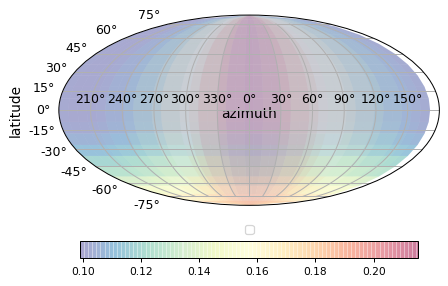

In [89]:
# Locate sources using DOA submodule
doa = pra.doa.SRP(mic_array, 
                  sample_rate, 
                  nfft, 
                  c=sound_speed, 
                  num_src=1, 
                  dim=3, 
                  azimuth=search_azimuth, 
                  colatitude=search_elevation)
doa.locate_sources(stft, freq_range=freq_range)

# Find direction of maximum energy
max_idx = doa.grid.find_peaks(k=1)[0]

# Get maximum azimuth angle
max_az = doa.grid.azimuth[max_idx]
if max_az < 0:
    max_az += 2 * np.pi

# Get maximum elevation angle
max_el = doa.grid.colatitude[max_idx]
max_el -= np.pi / 2
doa.grid.plot()

# Print out actual vs. estimated DOA
print('Actual azimuth (deg):', azimuth * (180 / np.pi))
print('Actual elevation (deg):', elevation * (180 / np.pi))
print('Estimated azimuth (deg):', max_az * (180 / np.pi))
print('Estimated elevation (deg):', max_el * (180 / np.pi))

### Real Audio
Perform sound source localization on all 8 channels captured from Matrix Voice.

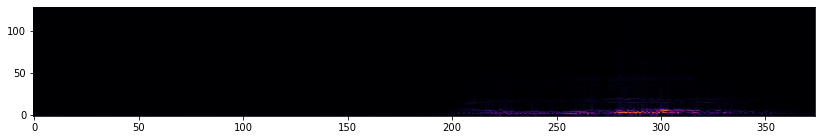

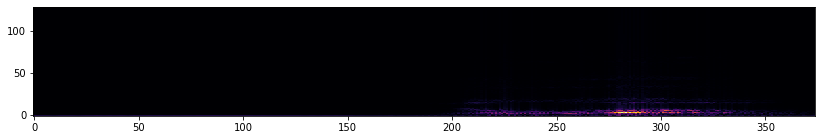

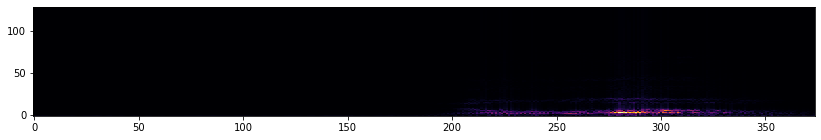

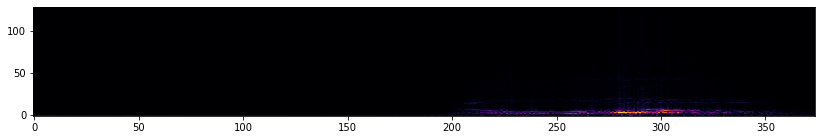

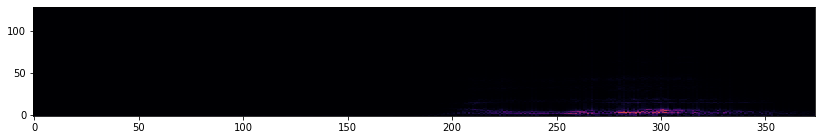

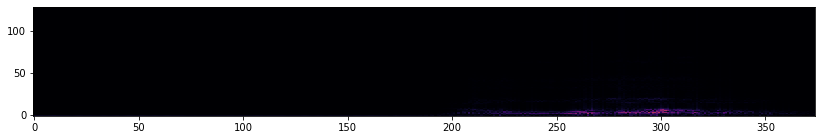

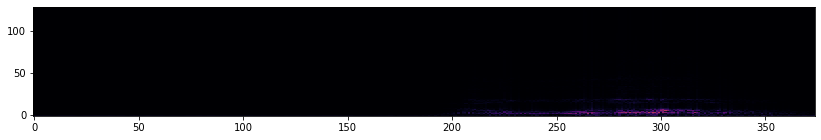

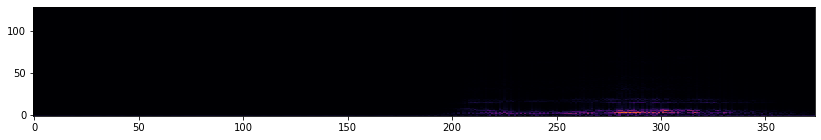

In [92]:
# Compute and plot STFT for all signals
stft = np.array([pra.stft(signal, nfft, nfft // 2, transform=np.fft.rfft).T for signal in signals])
for X in stft:
    fig = plt.figure(figsize=(14, 2))
    ax = fig.add_subplot(111)
    ax.imshow(np.absolute(X), cmap='inferno', origin='lower', aspect='auto')

No handles with labels found to put in legend.


Actual azimuth (deg): 0.0
Actual elevation (deg): 29.999999999999996
Estimated azimuth (deg): 180.0
Estimated elevation (deg): 74.48275862068967


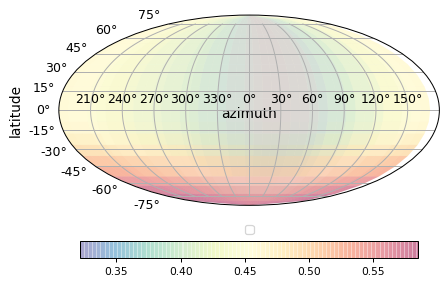

In [93]:
# Locate sources using DOA submodule
doa = pra.doa.SRP(mic_array, 
                  sample_rate, 
                  nfft, 
                  c=sound_speed, 
                  num_src=1, 
                  dim=3, 
                  azimuth=search_azimuth, 
                  colatitude=search_elevation)
doa.locate_sources(stft, freq_range=freq_range)

# Find direction of maximum energy
max_idx = doa.grid.find_peaks(k=1)[0]

# Get maximum azimuth angle
max_az = doa.grid.azimuth[max_idx]
if max_az < 0:
    max_az += 2 * np.pi

# Get maximum elevation angle
max_el = doa.grid.colatitude[max_idx]
max_el -= np.pi / 2
doa.grid.plot()

# Print out actual vs. estimated DOA
print('Actual azimuth (deg):', azimuth * (180 / np.pi))
print('Actual elevation (deg):', elevation * (180 / np.pi))
print('Estimated azimuth (deg):', max_az * (180 / np.pi))
print('Estimated elevation (deg):', max_el * (180 / np.pi))